# **Tópicos em Sistemas Inteligentes**


### **Trabalho Prático 1 - Computação Financeira**  
  
  
Desenvolver um conjunto de experimentos utilizando aprendizado de máquinas para criar estratégias de investimento automatizado. Para isso, deverá desenvolver, através da estrutura de simulação simplificada, a criação de uma base de dados para induzir modelos de Aprendizado de Máquinas Supervisionado (**AMS**) como forma de tomada de decisão. O framework sugerido deverá ser composto das seguintes etapas:

• **Etapa 1** - Criação da base de dados para Aprendizado Supervisionado:
desenvolvimento de algoritmo para criação de base de dados para ser utilizada na
indução de modelos de aprendizado de máquinas supervisionado  

• **Etapa 2** - Criação e Análise dos modelos de Aprendizado de Máquinas
Supervisionado: criação e validação dos modelos de aprendizado de máquinas
supervisionado. Nesta etapa, você deverá salvar as saídas dos modelos para serem
utilizados na etapa seguinte  

• **Etapa 3** - Criação de estratégias de investimento utilizando AM e análise de retorno: desenvolvimento de estratégia de investimento automatizado que utilize a saída dos modelos de aprendizado de máquinas como entrada para tomada de decisões. Nesta etapa, você deverá realizar a análise do retorno das estratégias dos modelos.  


Para o desenvolvimento dos experimentos, você deverá utilizar dados diários de
alguma ação pertencente ao Índice Bovespa

### **Instalação da TA-Lib para criação dos *features***


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=dec44ff3a7200d6b84711190b89ba727c303ee4389f4f12e9f44ce956b7f966a
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


### **Importação da Base de Dados em seu Formato *CSV***

In [2]:
import pandas as pd

# BRA - Eletrobras (ELET3)
df = pd.read_csv("./sample_data/eletrobras.csv")


## **Cálculo dos Indicadores de Análise Técnica**

### **Legenda**:  
. **MM**: Média Móvel  
. **MMC**: MM Curta  
. **MMM**: MM Média  
. **MML**: MM longa  
. **MMEXP**: MM Exponencial  
. **BB**: Bandas de *Bollinger* (Dada uma **MM**, as bandas de *Bollinger*, Inferior e Superior, consiste no incremento e decremento do Desvio Padrão da **MM** referencia dentro da própri **MM** escolhida)   
.

In [3]:
import ta
import numpy as np

# Moving Average
df['MMC7']  = ta.trend.sma_indicator(df['Close'], window=7)
df['MMM20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['MML50'] = ta.trend.sma_indicator(df['Close'], window=50)

df['MMC10']  = ta.trend.sma_indicator(df['Close'], window=10)
df['MMM30'] = ta.trend.sma_indicator(df['Close'], window=30)
df['MML100'] = ta.trend.sma_indicator(df['Close'], window=100)


# Stochastincs Indicators
df['KCurve'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
df['DCurve'] = ta.momentum.stoch_signal(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)

# Exponential Moving Average
df['MMEXP20'] = ta.trend.ema_indicator(df['Close'], window=20)

# Calculate Bollinger Bands with a window of 20 days

df['BBUpper'] = df['MMM20'] + (2.0 * ta.volatility.bollinger_hband(df['Close'], window=20, window_dev=0))
df['BBLower'] = df['MMM20'] - (2.0 * ta.volatility.bollinger_lband(df['Close'], window=20, window_dev=0))

# Others TAI
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['CCI'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
df['ROC'] = ta.momentum.ROCIndicator(df['Close'], window=14).roc()
df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=20).average_true_range()
df['ADI'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()

# Relative Vigor Index
numerator = df['Close'].diff()
denominator = df['Open'].diff()
df['RVI'] = numerator/ denominator

# Disparity Index
df['Disp_5']  = df['Close'] / df['Close'].rolling(window=5).mean()
df['Disp_7']  = df['Close'] / df['Close'].rolling(window=7).mean()
df['Disp_10'] = df['Close'] / df['Close'].rolling(window=10).mean()
df['Disp_20'] = df['Close'] / df['Close'].rolling(window=20).mean()

# Outputs - Label for the models
# Calculate the regressor output (GPT CODE!)
df['Return'] = df['Close'].shift(-1) - df['Close']

# Calculate the classifier output (GPT CODE!)
df['Action'] = (df['Return'] > 0).astype(int)

# LAG Features (return of the previous day)
df['Return_prev'] = (df['Return']).shift(1)
df['Return_log'] = np.log(df['Close']/ df['Close'].shift(1))


df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

#df.head(30)

### **Separação da Base em Treino-Teste (70%-30%)**

In [5]:
len_df = len(df)

train_length = round(0.7 * len_df)
test_length =  round(0.3 * len_df)

train_dataset = df[:train_length]
test_dataset =  df[train_length:]

### **Seleção das *Features* usados para indução dos modelos**

In [134]:
features = [
  #'Open',
  #'Close',
  'MMC7',
  'MMM20',
  'MML50',
  'MMC10',
  'MMM30',
  'MML100',
  'KCurve',
  'DCurve',
  'MMEXP20',
  'BBUpper',
  'BBLower',
  'RSI',
  'CCI',
  #'ROC',
  #'ATR',
  #'ADI',
  #'Disp_5',
  #'Disp_7',
  #'Disp_10',
  #'Disp_20',
  'RVI',
  #'Return_prev',
  'Return_log'
]

# Label to the Classifiers
target_cls = 'Action' # cls = classification

# Label to the Regressor
target_reg = 'Return' # reg = regression

# Train features
X_train = train_dataset[features]

# Training labels
y_train_clfs = train_dataset[target_cls]
y_train_regs = train_dataset[target_reg]

# Test features
X_test = test_dataset[features]

# Test labels
y_test_clfs = test_dataset[target_cls]
y_test_regs = test_dataset[target_reg]

### **Pré-Processamento da Base de Dados**

In [135]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Remobing the first 100 days to avoid blank features
X_train = X_train.iloc[99: ]
y_train_clfs = y_train_clfs.iloc[99: ]
y_train_regs = y_train_regs.iloc[99: ]

# Create a different Dataset Standardized
std_scaler = StandardScaler()
std_X_train = std_scaler.fit_transform(X_train)

mm_scaler = MinMaxScaler()
mm_X_train = mm_scaler.fit_transform(X_train)

### **Definição dos Objetivo - Cálculo do *BaseLine***

O *Baseline* serve como referencia para a *performance* dos modelos. O objetivo dos modelos é no mínimo ser MELHOR do que o *baseline*.

Para esse trabalho, o *Baseline* sera simplesmente a **Distrubuição da Classes Majoritária** presente na base de dados, ou seja, um modelo que "chuta" apenas um único valor (0 ou 1) para os **Classificadores**.

Para os **Regressores**, o *Baseline* será a Distância (**MAE** && **RMSE**) entre o retorno do dia anterior para o retorno do dia atual, ou seja, um modelo que chuta que o preço do mercado será constante entre os dias.

In [136]:
# Classifier Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

# Regressors Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Classifiers baseline
counts = test_dataset[target_cls].value_counts(normalize=True)

# The number of 0s is greater than the number of 1s?
if counts[0] > counts[1]:
  cls_baseline = (test_length) * [0]
else:
  cls_baseline = (test_length) * [1]

baseline_accuracy = accuracy_score(y_test_clfs, cls_baseline)
baseline_precision = precision_score(y_test_clfs, cls_baseline)
baseline_recall = recall_score(y_test_clfs, cls_baseline)

print("Baseline for Classifiers")
print(f"\t[+] ACCURACY:\t{baseline_accuracy}")
print(f"\t[+] PRECISION:\t{baseline_precision}")
print(f"\t[+] RECALL:\t{baseline_recall}")


# Regressors baseline
baseline_mae = mean_absolute_error(test_dataset['Return_prev'], test_dataset[target_reg])
baseline_rmse = np.sqrt(mean_squared_error(test_dataset['Return_prev'], test_dataset[target_reg]))

print(f'Regression Baseline:\n\t[+] MAE:\t{baseline_mae}')
print(f'\t[+] RMSE:\t{baseline_rmse}')

Baseline for Classifiers
	[+] ACCURACY:	0.5090470446320868
	[+] PRECISION:	0.5090470446320868
	[+] RECALL:	1.0
Regression Baseline:
	[+] MAE:	0.9388540410132687
	[+] RMSE:	1.212851418985683


### **Treinamento e Teste dos Modelos (Base de Dados NÃO normalizada)**

As métricas que estão em **VERMELHO** são as que foram **INFERIORES** ao *Baseline*. As **VERDES** são as **SUPERIORES**, ou seja as que atingiram a "Meta". As em **AZUIS** são que performaram **EXATAMENTE IGUAL** ao *Baseline*.

In [152]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
import xgboost as xgb

from sklearn.pipeline import Pipeline

# If x < y, print red, if equals print blue, else print green
def compare_numbers(x: float, y: float, growing=True) -> str:
  if x < y:
    if growing:
      return f'\033[0;31m{x}\033[0m'
    else:
      return f'\033[0;32m{x}\033[0m'
  elif x == y:
    return f'\033[0;34m{x}\033[0m'
  else:
    if growing:
      return f'\033[0;32m{x}\033[0m'
    else:
      return f'\033[0;31m{x}\033[0m'

# Define classifier models
classifier_models = [
    RandomForestClassifier(n_estimators=90, random_state=33),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVC(probability=True),
    KNeighborsClassifier(n_neighbors=5),
    xgb.XGBClassifier(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

# Define regressors models
regressor_models = [
    RandomForestRegressor(n_estimators=90, random_state=33),
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVR(),
    KNeighborsRegressor(n_neighbors=5),
    xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

guesstures = {}

# Train and evaluate each classifier model
for model in classifier_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(X_train, y_train_clfs)

    # Test
    y_pred_cls = model.predict(X_test)

    # Adding the model for future simulation
    guesstures[model_name] = y_pred_cls

    accuracy = accuracy_score(y_test_clfs, y_pred_cls)
    precision = precision_score(y_test_clfs, y_pred_cls)
    auc = roc_auc_score(y_test_clfs, model.predict_proba(X_test)[:, 1])
    recall = recall_score(y_test_clfs, y_pred_cls)

    print(f"\t[+] {model_name} ACCURACY: \t{compare_numbers(accuracy, baseline_accuracy)}")
    print(f"\t[+] {model_name} PRECISION:\t{compare_numbers(accuracy, baseline_precision)}")
    print(f"\t[+] {model_name} AUC:      \t{auc}")
    print(f"\t[+] {model_name} RECALL:   \t{compare_numbers(accuracy, baseline_recall)}")

    print("=" * 80)

# Train and evaluate each regressor model
for model in regressor_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(X_train, y_train_regs)

    # Test the model
    y_pred_reg = model.predict(X_test)

    # Adding the model for future simulation
    guesstures[model_name] = y_pred_cls

    mae = mean_absolute_error(y_test_regs, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_regs, y_pred_reg))

    print(f"\t[+] {model_name} MAE: \t{compare_numbers(mae, baseline_mae, False)}")
    print(f"\t[+] {model_name} RMSE:\t{compare_numbers(rmse, baseline_rmse, False)}")

    print("=" * 80)

Training RandomForestClassifier
	[+] RandomForestClassifier ACCURACY: 	0.5126658624849216
	[+] RandomForestClassifier PRECISION:	0.5126658624849216
	[+] RandomForestClassifier AUC:      	0.5249630285175308
	[+] RandomForestClassifier RECALL:   	0.5126658624849216
Training MLPClassifier
	[+] MLPClassifier ACCURACY: 	0.51145958986731
	[+] MLPClassifier PRECISION:	0.51145958986731
	[+] MLPClassifier AUC:      	0.5002678249123746
	[+] MLPClassifier RECALL:   	0.51145958986731
Training SVC
	[+] SVC ACCURACY: 	0.51145958986731
	[+] SVC PRECISION:	0.51145958986731
	[+] SVC AUC:      	0.4887833762241346
	[+] SVC RECALL:   	0.51145958986731
Training KNeighborsClassifier
	[+] KNeighborsClassifier ACCURACY: 	0.47406513872135103
	[+] KNeighborsClassifier PRECISION:	0.47406513872135103
	[+] KNeighborsClassifier AUC:      	0.46732244954993774
	[+] KNeighborsClassifier RECALL:   	0.47406513872135103
Training XGBClassifier
	[+] XGBClassifier ACCURACY: 	0.5126658624849216
	[+] XGBClassifier PRECISION:	

# **Treinamento dos Modelos (Base de Dados Normalizada)**

In [153]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
import xgboost as xgb

from sklearn.pipeline import Pipeline

# Define classifier models
classifier_models = [
    RandomForestClassifier(n_estimators=90, random_state=33),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVC(probability=True),
    KNeighborsClassifier(n_neighbors=5),
    xgb.XGBClassifier(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

# Define regressors models
regressor_models = [
    RandomForestRegressor(n_estimators=90, random_state=33),
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=33),
    SVR(),
    KNeighborsRegressor(n_neighbors=5),
    xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=90, random_state=33)
]

normalized_guesstures = {}

# Train and evaluate each classifier model
for model in classifier_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(std_X_train, y_train_clfs)

    # Test
    y_pred_cls = model.predict(X_test)

    # Adding the model for future simulation
    normalized_guesstures[model_name] = y_pred_cls

    accuracy = accuracy_score(y_test_clfs, y_pred_cls)
    precision = precision_score(y_test_clfs, y_pred_cls)
    auc = roc_auc_score(y_test_clfs, model.predict_proba(X_test)[:, 1])
    recall = recall_score(y_test_clfs, y_pred_cls)

    print(f"\t[+] {model_name} ACCURACY: \t{compare_numbers(accuracy, baseline_accuracy)}")
    print(f"\t[+] {model_name} PRECISION:\t{compare_numbers(precision, baseline_precision)}")
    print(f"\t[+] {model_name} AUC:      \t{auc}")
    print(f"\t[+] {model_name} RECALL:   \t{compare_numbers(recall, baseline_recall)}")

    print("=" * 80)

# Train and evaluate each regressor model
for model in regressor_models:
    model_name = type(model).__name__  # Get the name of the model class
    print(f"Training \033[1;97m{model_name}\033[0m")

    # Training
    model.fit(mm_X_train, y_train_regs)

    # Test the model
    y_pred_reg = model.predict(X_test)

    # Adding the model for future simulation
    normalized_guesstures[model_name] = y_pred_cls

    mae = mean_absolute_error(y_test_regs, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_regs, y_pred_reg))

    print(f"\t[+] {model_name} MAE: \t{compare_numbers(mae, baseline_mae, False)}")
    print(f"\t[+] {model_name} RMSE:\t{compare_numbers(rmse, baseline_rmse, False)}")

    print("=" * 80)

Training RandomForestClassifier
	[+] RandomForestClassifier ACCURACY: 	0.49095295536791317
	[+] RandomForestClassifier PRECISION:	0.0
	[+] RandomForestClassifier AUC:      	0.5125703040394983
	[+] RandomForestClassifier RECALL:   	0.0
Training MLPClassifier
	[+] MLPClassifier ACCURACY: 	0.51145958986731
	[+] MLPClassifier PRECISION:	0.5102781136638452
	[+] MLPClassifier AUC:      	0.5235656811486196
	[+] MLPClassifier RECALL:   	1.0
Training SVC
	[+] SVC ACCURACY: 	0.5090470446320868
	[+] SVC PRECISION:	0.5090470446320868
	[+] SVC AUC:      	0.5
	[+] SVC RECALL:   	1.0
Training KNeighborsClassifier
	[+] KNeighborsClassifier ACCURACY: 	0.5102533172496985
	[+] KNeighborsClassifier PRECISION:	0.5769230769230769
	[+] KNeighborsClassifier AUC:      	0.503874727808377
	[+] KNeighborsClassifier RECALL:   	0.14218009478672985
Training XGBClassifier
	[+] XGBClassifier ACCURACY: 	0.49095295536791317
	[+] XGBClassifier PRECISION:	0.0
	[+] XGBClassifier AUC:      	0.5073273402657289
	[+] XGBClassi

### **Simulação do Retorno**

#### Retorno x Risco && Retorno Acumulado ao longo do tempo

In [168]:
import matplotlib.pyplot as plt
from matplotlib import style

# State enumeration
class State:
  FLAT = 0
  SHORT = 1
  LONG = 2

# Generate days
days = []
for i in range(test_length):
  days.append(i)

# Return simulator
def return_simulator(y_pred):
  slippage = 0.01
  negotiated_volume = 1
  state = State.FLAT
  capital = 0
  daily_return = []

  for index, market in test_dataset.iterrows():
    day = len_df - index - 1

    # Buy
    if y_pred[day] > 0 and state != State.LONG:
      if state != State.FLAT:
        real_volume = 2 * negotiated_volume
      else:
        real_volume = negotiated_volume
      capital =  capital - ((market['Close'] + slippage) * real_volume)
      state = State.LONG

    # Sell
    elif y_pred[day] <= 0 and state != State.SHORT:
      if state != State.FLAT:
        real_volume = 2 * negotiated_volume
      else:
        real_volume = negotiated_volume
      capital = capital + ((market['Close'] - slippage) * real_volume)
      state = State.SHORT

    estimated_capital = capital

    if state == State.LONG:
      estimated_capital = capital + market['Close']

    elif state == State.SHORT:
      estimated_capital = capital - market['Close']

    daily_return.append(estimated_capital)
  return daily_return

def get_metrics(model_name, daily_return_1, daily_return_2):
  # Difference of daily returns

  dr_1 = [daily_return_1[i] - daily_return_1[i - 1] for i in range(1, len(daily_return_1))]
  dr_mean_1 = np.mean(dr_1, axis=0)
  dr_stdev_1 = np.std(dr_1)

  dr_2 = [daily_return_2[i] - daily_return_2[i - 1] for i in range(1, len(daily_return_2))]
  dr_mean_2 = np.mean(dr_2, axis=0)
  dr_stdev_2 = np.std(dr_2)

  print(80 * '=')
  print('\n')
  print(f'\033[1;97m{model_name}\033[0m Not Normalized')
  print(f"\t[+] Mean:              \t{compare_numbers(dr_mean_1, 0)}")
  print(f"\t[+] Standard Deviation:\t{compare_numbers(dr_stdev_1, dr_stdev_2, False)}")
  print('\n')
  print(f'\033[1;97m{model_name}\033[0m Normalized')
  print(f"\t[+] Mean:              \t{compare_numbers(dr_mean_2, 0)}")
  print(f"\t[+] Standard Deviation:\t{compare_numbers(dr_stdev_2, dr_stdev_1, False)}")
  print('\n')

  '''plt.plot(days, daily_return, linewidth=2)
    plt.title('Accrued Return over time')
    plt.xlabel('Days')
    plt.ylabel('Accrued Return')
    #plt.grid(True)
    plt.style.use('dark_background')
    plt.show()'''

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  ax1.plot(days, daily_return_1, linewidth=2)
  ax1.set_title(f'Not Normalized Dataset: {model_name}')
  ax1.set_xlabel('Days')
  ax1.set_ylabel('Accrued Return')

  # Plot the second graph on the right subplot
  ax2.plot(days, daily_return_2, linewidth=2)
  ax2.set_title(f'Normalized Dataset: {model_name}')
  ax2.set_xlabel('Days')
  ax2.set_ylabel('Accrued Return')

  # Adjust layout to prevent overlapping
  plt.tight_layout()
  plt.style.use('dark_background')
  plt.show()

  metrics = [dr_mean_1, dr_stdev_1, dr_mean_2, dr_stdev_2]

  return metrics

# **Retorno Acumulado por Cada Modelo**


# **Conjunto dos Retornos dos modelos**

In [157]:
models_performance = {}

## ***Random Forest Classifier***



RandomForestClassifier Not Normalized
	[+] Mean:              	-0.02817632850241442
	[+] Standard Deviation:	0.8378354806164257


RandomForestClassifier Normalized
	[+] Mean:              	-0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




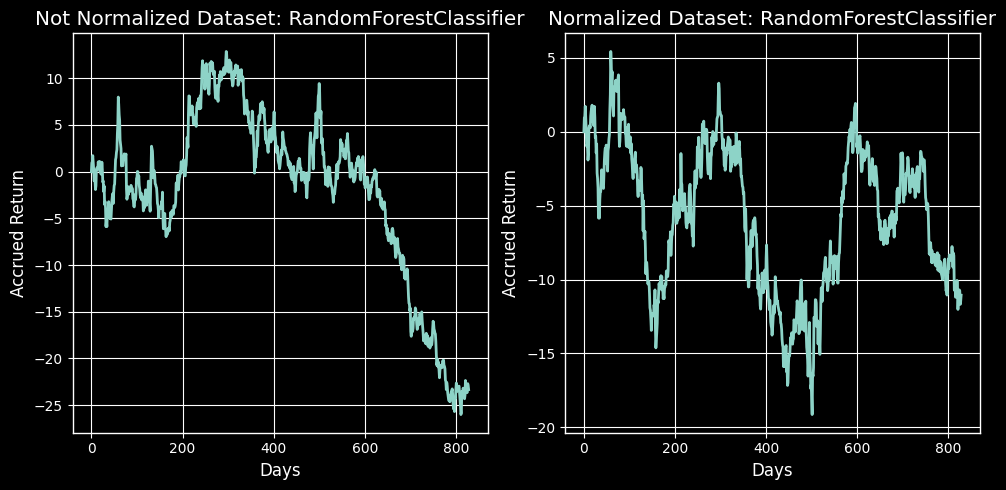

In [169]:
model_name = 'RandomForestClassifier'
#return_list = return_simulator(simulation_predictions[model_name])
return_rfc = return_simulator(guesstures[model_name])
normalized_return_rfc = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_rfc, normalized_return_rfc)

## ***MultiLayer Perceptron Classifier***



MLPClassifier Not Normalized
	[+] Mean:              	-0.0455193236714968
	[+] Standard Deviation:	0.83759567676925


MLPClassifier Normalized
	[+] Mean:              	0.011195652173913056
	[+] Standard Deviation:	0.8385993875115337




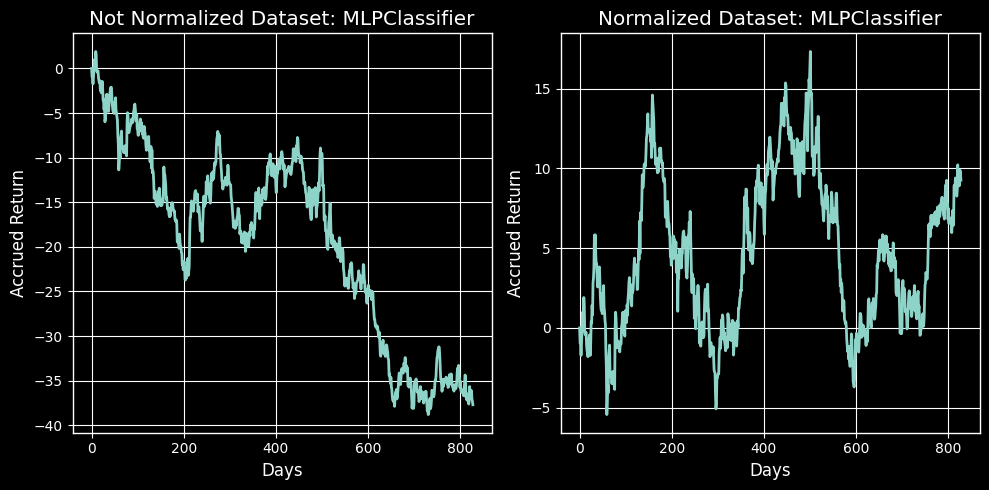

In [170]:
model_name = 'MLPClassifier'
return_mlpc = return_simulator(guesstures[model_name])
normalized_return_mlpc = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_mlpc, normalized_return_mlpc)

## ***Support Vector Classifier (SVC)***



SVC Not Normalized
	[+] Mean:              	-0.00803140096618305
	[+] Standard Deviation:	0.8386707990379222


SVC Normalized
	[+] Mean:              	0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




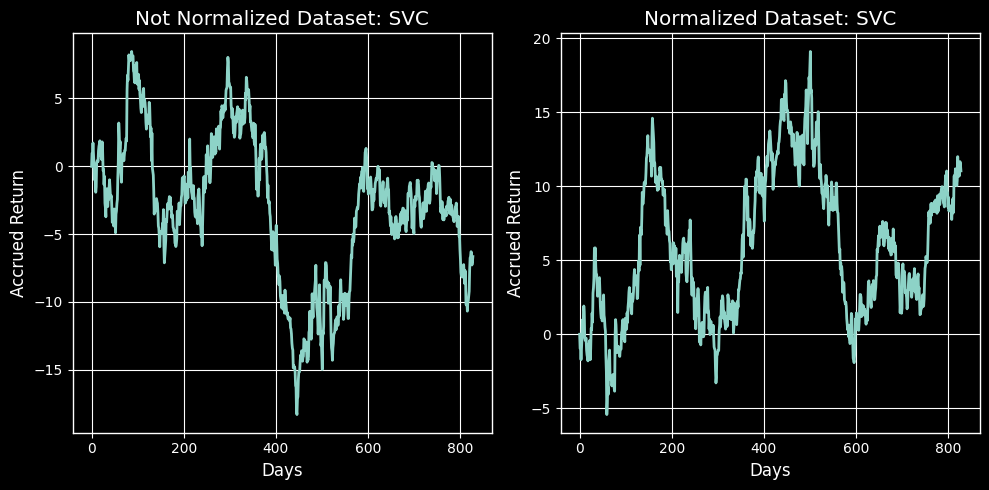

In [171]:
model_name = 'SVC'
return_svc = return_simulator(guesstures[model_name])
normalized_return_svc = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_svc, normalized_return_svc)

## ***K-Neighbors Classifier (KNN)***



KNeighborsClassifier Not Normalized
	[+] Mean:              	-6.038647342828346e-05
	[+] Standard Deviation:	0.8384883287875234


KNeighborsClassifier Normalized
	[+] Mean:              	-0.011871980676328183
	[+] Standard Deviation:	0.8384777430797065




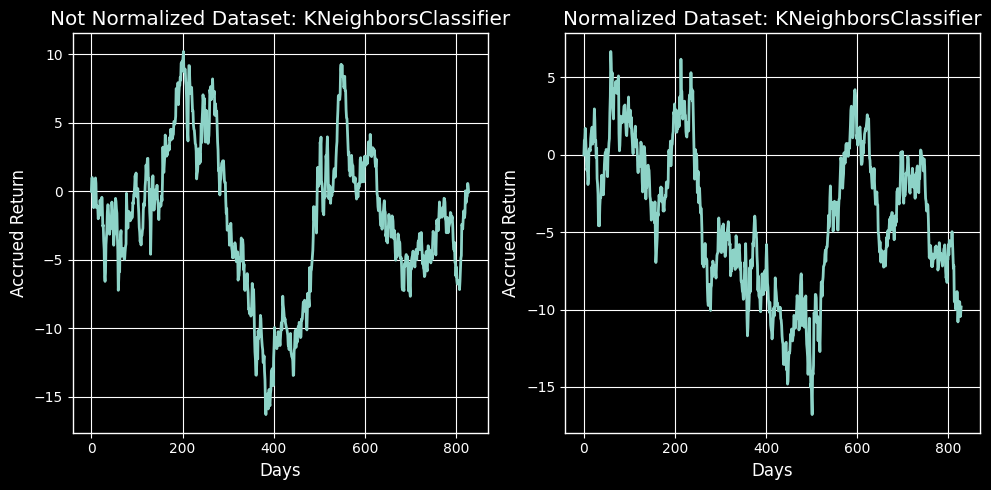

In [173]:
model_name = 'KNeighborsClassifier'
return_knnc = return_simulator(guesstures[model_name])
normalized_return_knnc = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_knnc, normalized_return_knnc)

## ***XGBoost Classifier***




XGBClassifier Not Normalized
	[+] Mean:              	-0.02846618357487859
	[+] Standard Deviation:	0.8380456273342941


XGBClassifier Normalized
	[+] Mean:              	-0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




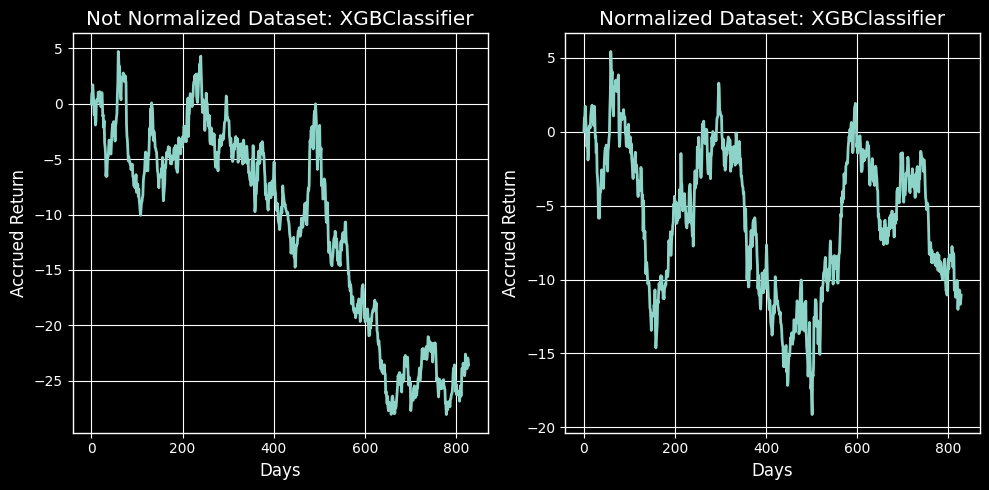

In [174]:
model_name = 'XGBClassifier'
return_xgbc = return_simulator(guesstures[model_name])
normalized_return_xgbc = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_xgbc, normalized_return_xgbc)

## ***Random Forest Regressor***



RandomForestRegressor Not Normalized
	[+] Mean:              	-0.02846618357487859
	[+] Standard Deviation:	0.8380456273342941


RandomForestRegressor Normalized
	[+] Mean:              	-0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




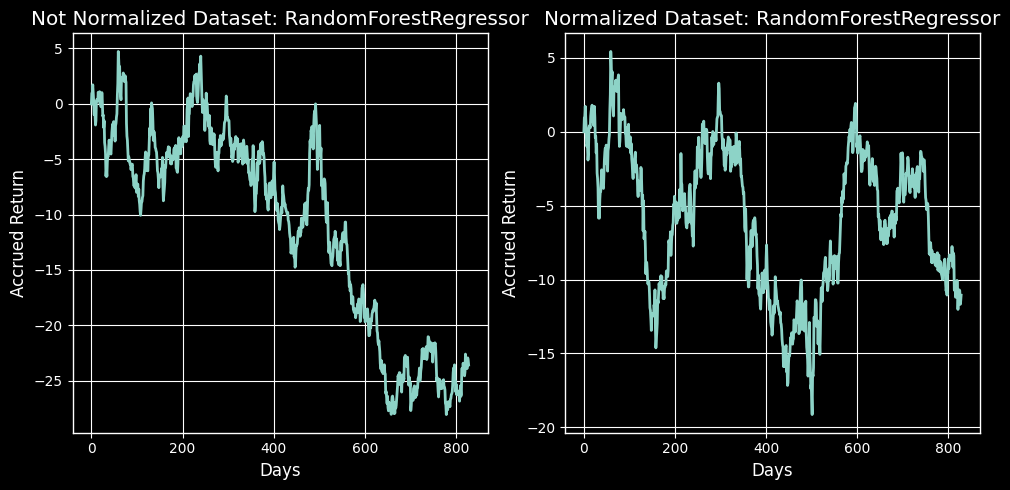

In [175]:
model_name = 'RandomForestRegressor'
return_rfr = return_simulator(guesstures[model_name])
normalized_return_rfr = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_rfr, normalized_return_rfr)

## ***MultiLayer Perceptron Regressor***



MLPRegressor Not Normalized
	[+] Mean:              	-0.02846618357487859
	[+] Standard Deviation:	0.8380456273342941


MLPRegressor Normalized
	[+] Mean:              	-0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




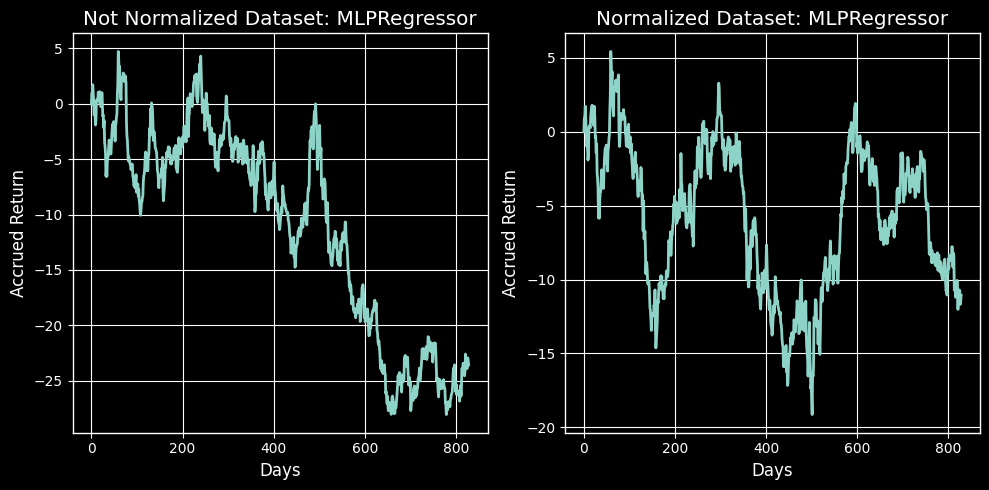

In [176]:
model_name = 'MLPRegressor'
return_mlpr = return_simulator(guesstures[model_name])
normalized_return_mlpr = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_mlpr, normalized_return_mlpr)

## ***Support Vector Regressor (SVR)***



SVR Not Normalized
	[+] Mean:              	-0.02846618357487859
	[+] Standard Deviation:	0.8380456273342941


SVR Normalized
	[+] Mean:              	-0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




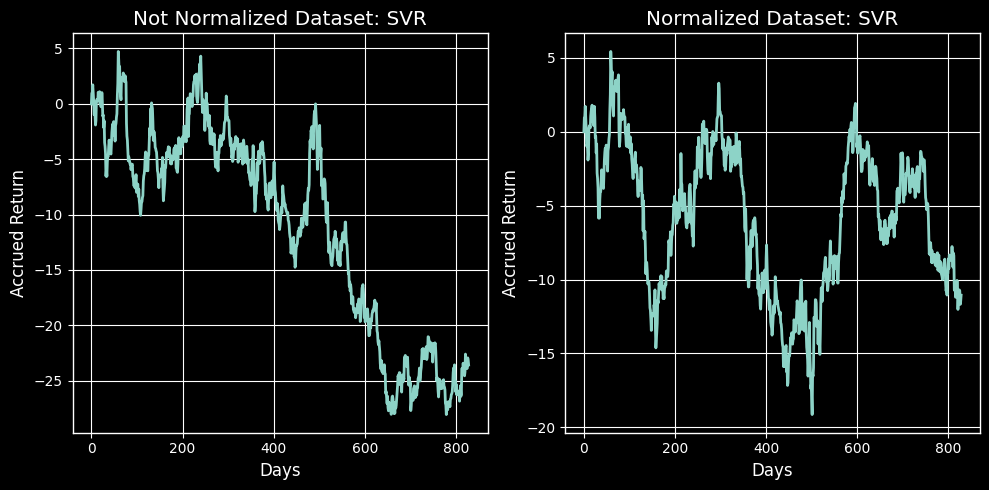

In [177]:
model_name = 'SVR'
return_svr = return_simulator(guesstures[model_name])
normalized_return_svr = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_svr, normalized_return_svr)

## ***K-Neighbors Regressor (KNN)***



KNeighborsRegressor Not Normalized
	[+] Mean:              	-0.02846618357487859
	[+] Standard Deviation:	0.8380456273342941


KNeighborsRegressor Normalized
	[+] Mean:              	-0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




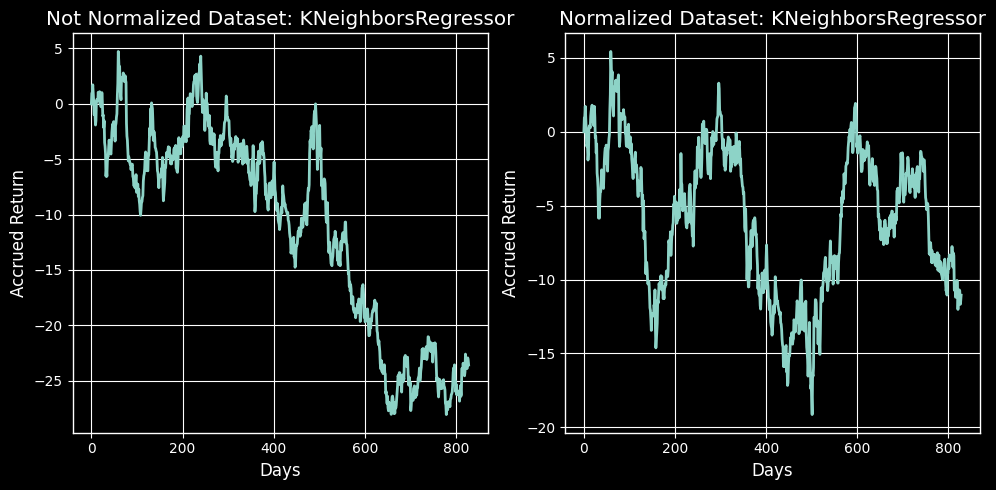

In [178]:
model_name = 'KNeighborsRegressor'
return_knnr = return_simulator(guesstures[model_name])
normalized_return_knnr = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_knnr, normalized_return_knnr)

## ***XGBoostRegressor (XGB)***



XGBRegressor Not Normalized
	[+] Mean:              	-0.02846618357487859
	[+] Standard Deviation:	0.8380456273342941


XGBRegressor Normalized
	[+] Mean:              	-0.01334541062801932
	[+] Standard Deviation:	0.8385068633699734




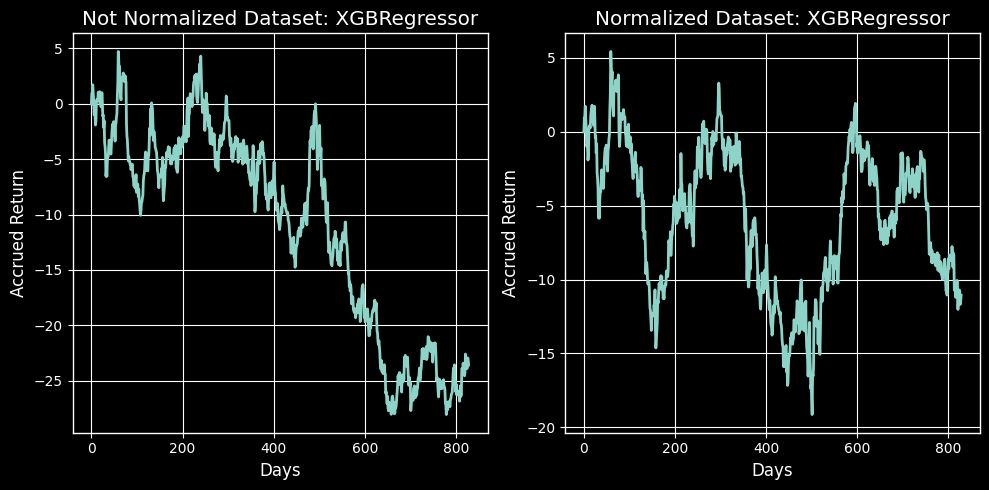

In [179]:
model_name = 'XGBRegressor'
return_xgbr = return_simulator(guesstures[model_name])
normalized_return_xgbr = return_simulator(normalized_guesstures[model_name])
models_performance[model_name] = get_metrics(model_name, return_xgbr, normalized_return_xgbr)

# **Visualizando o Retorno x Risco**

### Quanto **Maior** o Retorno e **Menor** o Risco, MELHOR!

[-0.02817632850241442, 0.8378354806164257, -0.01334541062801932, 0.8385068633699734]
[-0.0455193236714968, 0.83759567676925, 0.011195652173913056, 0.8385993875115337]
[-0.00803140096618305, 0.8386707990379222, 0.01334541062801932, 0.8385068633699734]
[-6.038647342828346e-05, 0.8384883287875234, -0.011871980676328183, 0.8384777430797065]
[-0.02846618357487859, 0.8380456273342941, -0.01334541062801932, 0.8385068633699734]
[-0.02846618357487859, 0.8380456273342941, -0.01334541062801932, 0.8385068633699734]
[-0.02846618357487859, 0.8380456273342941, -0.01334541062801932, 0.8385068633699734]
[-0.02846618357487859, 0.8380456273342941, -0.01334541062801932, 0.8385068633699734]
[-0.02846618357487859, 0.8380456273342941, -0.01334541062801932, 0.8385068633699734]
[-0.02846618357487859, 0.8380456273342941, -0.01334541062801932, 0.8385068633699734]


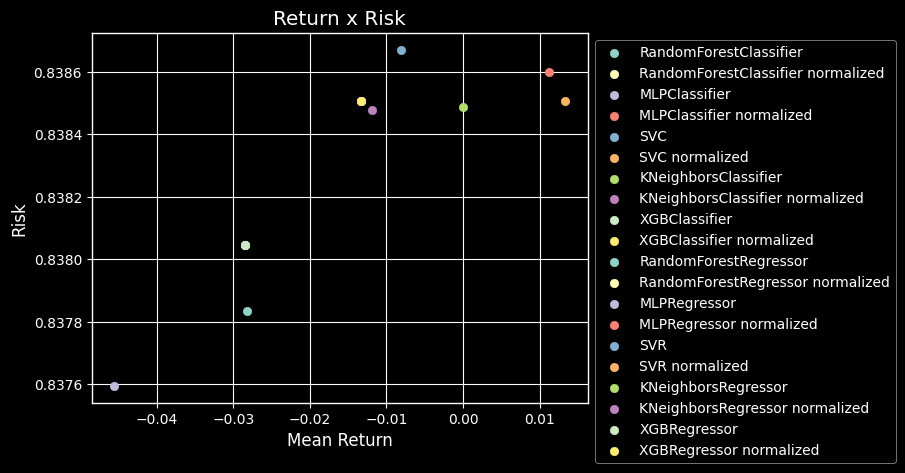

In [180]:
for model_name, model_metrics in models_performance.items():
  print(model_metrics)
  a, b, c, d = model_metrics
  plt.scatter(a, b, label=model_name)
  plt.scatter(c, d, label=f'{model_name} normalized')

plt.xlabel('Mean Return')
plt.ylabel('Risk')
plt.title('Return x Risk')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Como podemos observar no gráfico, os modelos ***MLPClassifier*** e o ***Support Vector Classifier (SVC)*** da base normalizada foram os modelos que obtiveram um retorno **POSITIVO** na simulação. Porém apenas o ***MLPClassifier*** conseguiu bater a meta, já que o primeiro teve a exata mesmo performance do *Baseline*!. Ou seja, os modelos não foram bem! Para o próximo trabalho tentaremos implementar uma estratégia mais sofisticada para melhorar a performance dos modelo. Aplicaremos a Técnica de ***Ensemble***.